# Noise

Testing applying different kinds of noises to images to check a network's robustness 

In [1]:
import torch
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image

from torchvision.models import resnet18
from torchvision.models import ResNet18_Weights
from torchvision.transforms.v2 import ToTensor, ToPILImage

import json

# Initial Setup Testing

In [2]:
with open("imagenet-simple-labels.json", "r") as f:
    label_list = json.load(f)
    INDEX_TO_LABEL = {index:label.title() for index, label in enumerate(label_list)}

In [3]:
image = Image.open("images/golden.jpeg")
# image = image.resize((256, 256))
image_np = np.array(image) / 255
image_np.shape

(625, 863, 3)

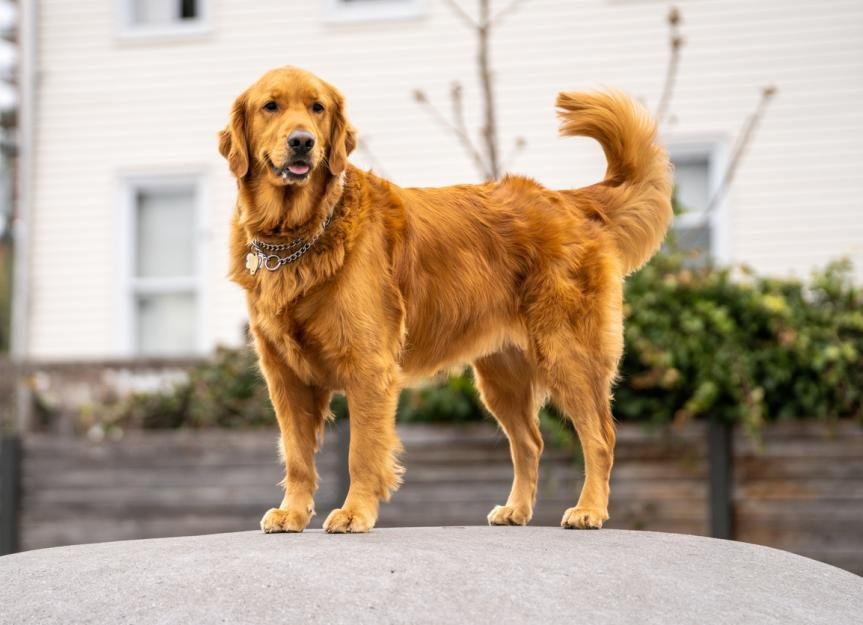

In [4]:
image

In [5]:
model = resnet18(weights=ResNet18_Weights)
target_layers = [model.layer4[-1]]
input_tensor = ToTensor()(image).unsqueeze(0)
input_tensor.size()

/Users/fernando.cruz/Documents/Universidade/TCC/gradcam-experiments/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/fernando.cruz/Documents/Universidade/TCC/gradcam-experiments/.venv/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


torch.Size([1, 3, 625, 863])

In [6]:
model.eval()
with torch.no_grad():
    result = model(input_tensor)
result_index = torch.argmax(result).item()
print(INDEX_TO_LABEL[result_index])
print(result_index)

Golden Retriever
207


In [7]:
targets = [ClassifierOutputTarget(result_index)]

In [8]:
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(image_np.astype(np.float32), grayscale_cam, use_rgb=True)
    model_outputs = cam.outputs

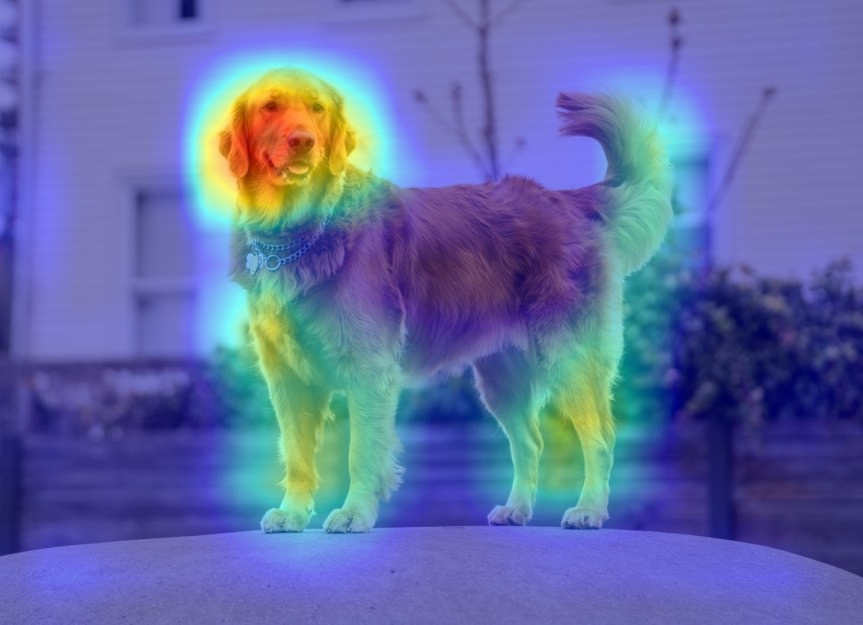

In [9]:
Image.fromarray(visualization)

# Setup GradCam Functions

In [10]:
def load_image(path, resize=None):
    image = Image.open(path)
    if resize is not None:
        image = image.resize(resize)
    
    return image

def show_image_np(image_np):
    return Image.fromarray(image_np)

def pil_to_tensor(image):
    to_tensor = ToTensor()
    return to_tensor(image).unsqueeze(0)

def tensor_to_pil(image_tensor):
    to_pil = ToPILImage()
    return to_pil(image_tensor.squeeze(0))

def tensor_to_np(image_tensor):
    image = tensor_to_pil(image_tensor)
    image_np = np.array(image).astype(np.float32)
    return image_np / 255

In [11]:
@torch.no_grad()
def get_max_index(image_tensor, model):
    model.eval()
    result = model(image_tensor)
    return torch.argmax(result).item()

def get_max_indexes(images_tensor, model):
    return [get_max_index(image_tensor, model) for image_tensor in images_tensor]

def gradcam(image_tensor, model, index=None, target_layers=None):
    if target_layers is None:
        target_layers = [model.layer4[-1]]
    
    if index is None:
        index = get_max_index(image_tensor, model)
    targets = [ClassifierOutputTarget(index)] 

    with GradCAM(model=model, target_layers=target_layers) as cam:
        grayscale_cam = cam(input_tensor=image_tensor, targets=targets)
    
    grayscale_cam = grayscale_cam[0, :]
    return show_cam_on_image(tensor_to_np(image_tensor), grayscale_cam, use_rgb=True)

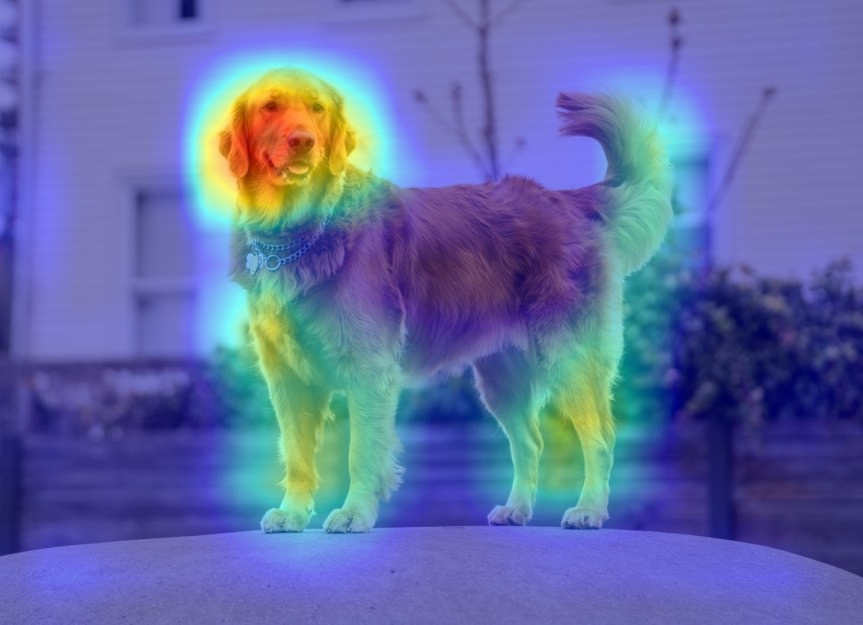

In [12]:
image_tensor = pil_to_tensor(image)
grad = gradcam(image_tensor, model)
show_image_np(grad)

In [13]:
def load_images(path_list, resize=None):
    return [load_image(path, resize=resize) for path in path_list]

In [14]:
def gradcam_images(images_tensor, model, indexes=None, target_layers=None):
    if indexes is None:
        return [gradcam(image_tensor, model, index=None, target_layers=target_layers) for image_tensor in images_tensor]
    
    return [gradcam(image_tensor, model, index=index, target_layers=target_layers) for image_tensor, index in zip(images_tensor, indexes)]

# Setup Experiments

In [15]:
from torchvision.transforms.v2 import GaussianBlur, GaussianNoise, ColorJitter

In [16]:
path_list = ["images/police-car.jpg"]
images = load_images(path_list)
images_tensor = [pil_to_tensor(image) for image in images]

In [17]:
blur_experiments_parameters = [{"kernel_size":k} for k in [3, 5, 7]]
noise_experiments_parameters = [{"sigma":s} for s in [0.1, 0.2, 0.25, 0.4, 0.6, 0.8]]
jitter_brightness_experiments_parameters = [{"brightness":(b,b)} for b in [0.5, 2.5, 3.5, 4.5, 9]]
jitter_contrast_experiments_parameters = [{"contrast":(b,b)} for b in [0.1, 0.2, 0.5, 1.2, 2.7]]
jitter_saturation_experiments_parameters = [{"saturation":(b,b)} for b in [0.1, 0.2, 0.3, 0.4, 0.5, 1.1, 1.2, 1.3, 1.4, 1.5, 2.7]]

experiment_map = {
    # Map from experiment name to a tuple of a list of experiments and their parameters used
    # "Blur":([GaussianBlur(**exp) for exp in blur_experiments_parameters], blur_experiments_parameters),
    "Noise":([GaussianNoise(**exp) for exp in noise_experiments_parameters], noise_experiments_parameters),
    # "Brightness":([ColorJitter(**exp) for exp in jitter_brightness_experiments_parameters], jitter_brightness_experiments_parameters),
    "Contrast":([ColorJitter(**exp) for exp in jitter_contrast_experiments_parameters], jitter_contrast_experiments_parameters),
    # "Saturation":([ColorJitter(**exp) for exp in jitter_saturation_experiments_parameters], jitter_saturation_experiments_parameters),
}

In [18]:
from matplotlib import pyplot as plt

In [19]:
def run_experiments(images_tensor, indexes, model, experiments):
    # returns all images ran in the experiment and their gradcams
    empty_experiment = lambda x: x
    experiments = [empty_experiment] + experiments
    transformed_images_tensor = [[exp(image) for exp in experiments] for image in images_tensor]
    all_images_tensor = transformed_images_tensor
    # GradCam Indexes of orginal images
    original_indexes_experiments = [[index for _ in experiments] for index in indexes]
    # GradCam Indexes for new transformed images
    transformed_indexes_experiments = [get_max_indexes(image_exp_col, model) for image_exp_col in all_images_tensor]

    cam_images_original_index = [gradcam_images(images_exp, model, indexes=indexes_experiment) for images_exp, indexes_experiment in zip(all_images_tensor, original_indexes_experiments)]
    cam_images_transformed_index = [gradcam_images(images_exp, model, indexes=indexes_experiment) for images_exp, indexes_experiment in zip(all_images_tensor, transformed_indexes_experiments)]
    return all_images_tensor, cam_images_original_index, (cam_images_transformed_index, transformed_indexes_experiments)

In [20]:
def format_parameters(experiment_params):
    return ", ".join(f"{key}: {value}" for key, value in experiment_params.items())

In [21]:
def get_fig_name(experiments_name, experiment_params, index):
    return f"{experiments_name}({','.join(experiment_params.keys())}): {INDEX_TO_LABEL[index]} [{index}].png"

In [22]:
def save_experiments(
        images_object, 
        cam_images_original_index_object,
        cam_images_transformed_index_object,
        original_index,
        transformed_indexes,
        experiments_name, 
        experiments_params, 
    ):
    print(f"imgs obj len: {len(images_object)}")
    rows, cols = 3, len(images_object)
    fig, axes = plt.subplots(rows, cols, figsize=(2*len(images_object) + 5, 7))

    fig.suptitle(f"{experiments_name}: {INDEX_TO_LABEL[original_index]} [{original_index}]")

    row_titles = ["Images", "Original Class", "Top Class"]
    for row_idx, title in enumerate(row_titles):
        axes[row_idx, 0].set_ylabel(title, rotation=90, size="large")

    axes[0, 0].imshow(images_object[0])
    # axes[0, 0].axis("off")
    axes[0, 0].set_title("Original")
    axes[0, 0].set_yticks([])
    axes[0, 0].set_xticks([])
    for i, (image, experiment_params) in enumerate(zip(images_object[1:], experiments_params), start=1):
        axes[0, i].imshow(image)
        # axes[0, i].axis("off")
        axes[0, i].set_title(format_parameters(experiment_params))
        axes[0, i].set_yticks([])
        axes[0, i].set_xticks([])

    for i, cam_image in enumerate(cam_images_original_index_object):
        axes[1, i].imshow(cam_image)
        # axes[1, i].axis("off")
        axes[1, i].set_yticks([])
        axes[1, i].set_xticks([])
    for i, cam_image in enumerate(cam_images_transformed_index_object):
        axes[2, i].imshow(cam_image)
        # axes[2, i].axis("off")
        index = transformed_indexes[i]
        axes[2, i].set_yticks([])
        axes[2, i].set_xticks([])
        axes[2, i].set_title(f"[{index}] {INDEX_TO_LABEL[index]}")
    
    plt.tight_layout()
    fig.savefig(get_fig_name(experiments_name, experiment_params, original_index))

imgs obj len: 7
imgs obj len: 6


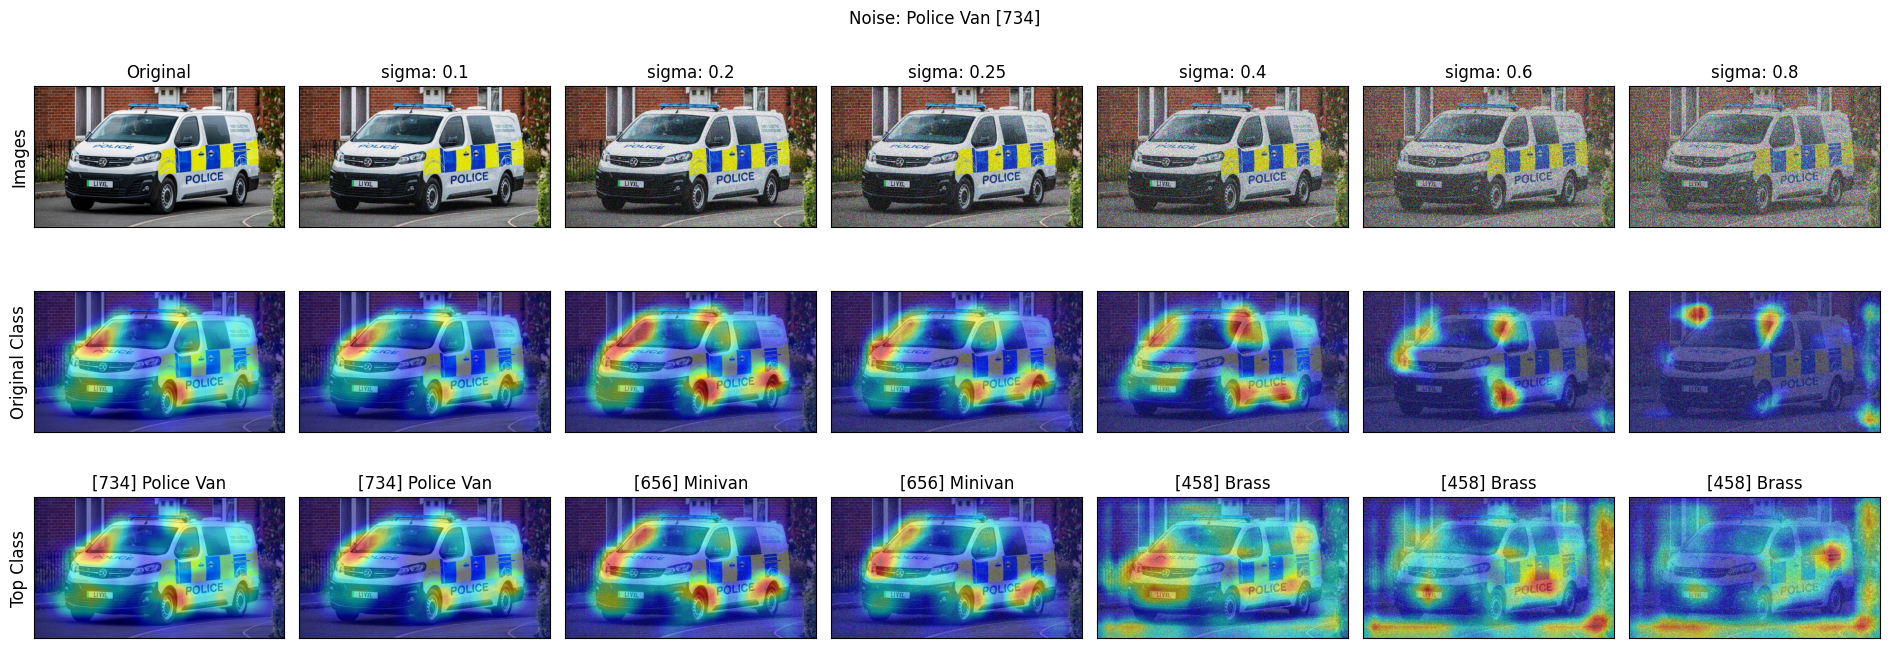

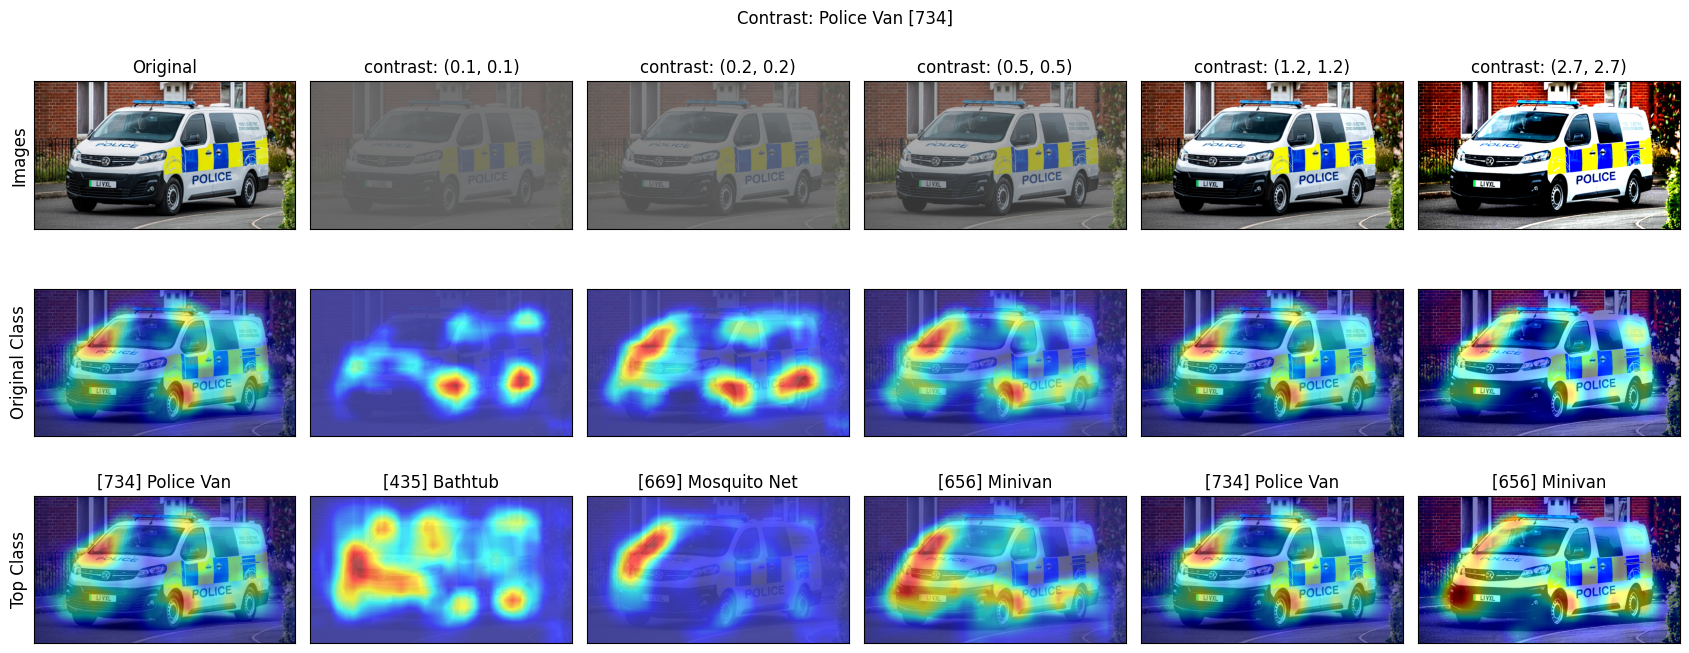

In [23]:
indexes = get_max_indexes(images_tensor, model)
# requires images_tensor, model
for experiments_name, experiments_config in experiment_map.items():
    experiments, experiments_params = experiments_config
    all_images_tensor, cam_images_original_index, (cam_images_transformed_index, transformed_indexes) = run_experiments(images_tensor, indexes, model, experiments)
    all_images = [[tensor_to_np(image_tensor) for image_tensor in images_tensor] for images_tensor in all_images_tensor]

    for images_object, cam_images_original_object, cam_images_transformed_object, original_index, transformed_index in zip(all_images, cam_images_original_index, cam_images_transformed_index, indexes, transformed_indexes):
        save_experiments(images_object, cam_images_original_object, cam_images_transformed_object, original_index, transformed_index, experiments_name, experiments_params)

In [24]:
import os
from datetime import datetime

In [25]:
def create_experiment_folder():
    # Get the current time and format it as a string
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    # Define the folder name with the timestamp
    folder_name = f"experiments/experiment_{timestamp}"

    # Create the folder
    os.makedirs(folder_name, exist_ok=True)

    return folder_name

In [26]:
def run_experiments_batch(images_tensor, model, experiment_map):
    indexes = get_max_indexes(images_tensor, model)
    folder_name = create_experiment_folder()
    default_dir = os.getcwd()
    os.chdir(folder_name)

    for experiments_name, experiments_config in experiment_map.items():
        experiments, experiments_params = experiments_config
        all_images_tensor, cam_images, _ = run_experiments(images_tensor, indexes, model, experiments)
        all_images = [[tensor_to_np(image_tensor) for image_tensor in images_tensor] for images_tensor in all_images_tensor]

        for images_object, cam_images_object, index in zip(all_images, cam_images, indexes):
            save_experiments(images_object, cam_images_object, experiments_name, experiments_params, index)
    
    os.chdir(default_dir)

In [27]:
run_experiments_batch(images_tensor, model, experiment_map)

TypeError: save_experiments() missing 2 required positional arguments: 'experiments_name' and 'experiments_params'